## Import the necessary libraries

In [1]:
import pandas as pd                                    #Data Manipulation library
import numpy as np                                     #Numerical Computing library
import matplotlib.pyplot as plt                        #Data Visualization library
import seaborn as sns                                  #Data Visualization library built on top of Matplotlib
from sklearn.preprocessing import MinMaxScaler         #Feature scaling method
from sklearn.impute import SimpleImputer               #Handling missing data
import joblib                                          #Importing & Exporting Model/Parameters

#Splitting datasets into training and testing sets
from sklearn.model_selection import train_test_split   

#Evaluation metrics for machine learning models
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, classification_report

## Load Datasets

In [2]:
triage_data = pd.read_csv("/kaggle/input/triage/triage.csv")
edstays_data = pd.read_csv("/kaggle/input/triage/edstays.csv")

In [3]:
# Merge the two datasets on the 'subject_id' and 'stay_id' columns
merged_dataset = pd.merge(triage_data, edstays_data[['subject_id','stay_id','intime','disposition']], on=['subject_id','stay_id'])

In [4]:
merged_dataset.head()

,subject_id,stay_id,temperature,heartrate,resprate,o2sat,sbp,dbp,pain,acuity,chiefcomplaint,intime,disposition
0,10000032,32952584,97.8,87.0,14.0,97.0,71.0,43.0,7,2.0,Hypotension,2180-07-22 16:24:00,HOME
1,10000032,33258284,98.4,70.0,16.0,97.0,106.0,63.0,0,3.0,"Abd pain, Abdominal distention",2180-05-06 19:17:00,ADMITTED
2,10000032,35968195,99.4,105.0,18.0,96.0,106.0,57.0,10,3.0,"n/v/d, Abd pain",2180-08-05 20:58:00,ADMITTED
3,10000032,38112554,98.9,88.0,18.0,97.0,116.0,88.0,10,3.0,Abdominal distention,2180-06-26 15:54:00,ADMITTED
4,10000032,39399961,98.7,77.0,16.0,98.0,96.0,50.0,13,2.0,"Abdominal distention, Abd pain, LETHAGIC",2180-07-23 05:54:00,ADMITTED


In [5]:
dataset = merged_dataset[["temperature", "heartrate", "resprate", "o2sat", "sbp", "dbp","acuity"]]

In [6]:
# Count the amount of data before preprocessing
count_before = len(dataset)
print("Data count before: ", count_before)

Data count before:  425087


## Data Pre-processing

### Drop Null Values

In [7]:
dataset.dropna(axis=0, how='any', inplace=True)

/opt/conda/lib/python3.7/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


### Check for Non-numeric Data

In [8]:
for column in dataset.columns:
    try:
        pd.to_numeric(dataset[column])
    except ValueError:
        print(f"{column} contains non-numeric data.")

In [9]:
dataset.head(5)

,temperature,heartrate,resprate,o2sat,sbp,dbp,acuity
0,97.8,87.0,14.0,97.0,71.0,43.0,2.0
1,98.4,70.0,16.0,97.0,106.0,63.0,3.0
2,99.4,105.0,18.0,96.0,106.0,57.0,3.0
3,98.9,88.0,18.0,97.0,116.0,88.0,3.0
4,98.7,77.0,16.0,98.0,96.0,50.0,2.0


### Data Normalization

In [10]:
# Normalization
scaler = MinMaxScaler()
columns = ["temperature", "heartrate", "resprate", "o2sat", "sbp", "dbp"]
dataset[columns] = scaler.fit_transform(dataset[columns])

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


In [11]:
import pickle
min_value, max_value = scaler.data_min_, scaler.data_max_
# Dump the model to a file
with open('status_scaler.pkl', 'wb') as file:
    pickle.dump((min_value, max_value), file)

In [12]:
dataset.head(5)

,temperature,heartrate,resprate,o2sat,sbp,dbp,acuity
0,0.099097,0.077617,0.007692,0.010405,0.003345,0.000065,2.0
1,0.099706,0.062274,0.008791,0.010405,0.005119,0.000095,3.0
2,0.100720,0.093863,0.009890,0.010298,0.005119,0.000086,3.0
3,0.100213,0.078520,0.009890,0.010405,0.005626,0.000133,3.0
4,0.100010,0.068592,0.008791,0.010513,0.004612,0.000076,2.0


In [13]:
# Count the amount of data after preprocessing
count_after = len(dataset)
print("Data after normalization: ", count_after)

Data after normalization:  392462


In [14]:
# sample 50% of your dataframe
dataset2 = dataset.sample(frac=0.1)

In [15]:
# Count the amount of data after preprocessing
checksize = len(dataset2)
print("Data after resize: ", checksize)

Data after resize:  39246


## Checking Dataset for Imbalance

Float64Index([3.0, 2.0, 4.0, 1.0, 5.0], dtype='float64')
[55.83753758 33.32059318  6.90006625  3.67935586  0.26244713]


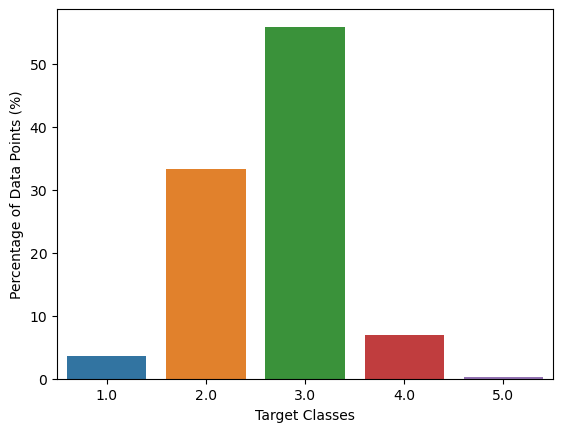

In [16]:
# Get the value counts for the target column
target_counts = dataset2['acuity'].value_counts()

# Calculate the percentage of data points for each class
target_percentage = target_counts / dataset2.shape[0] * 100

# Plot the distribution using seaborn
sns.barplot(x=target_percentage.index, y=target_percentage.values)

print(target_percentage.index)
print(target_percentage.values)

plt.xlabel('Target Classes')
plt.ylabel('Percentage of Data Points (%)')
plt.show()

Dataset is imbalanced. However performing oversampling or undersampling will heavily reduce model accuracy to the 20s.<br>

Will be performing a combination of oversampling and undersampling although this will not balance the data, we just want to improve the accuracy of successfully classifying classes 1 and classes 5 under the target column.

## Combination Sampling

Combining over-sampling and under-sampling methods for imbalanced datasets

In [17]:
from imblearn.combine import SMOTEENN

In [18]:
# Get the features and target columns
X = dataset2[['temperature','heartrate','resprate','o2sat','sbp','dbp']]
y = dataset2['acuity']

In [19]:
# Perform SMOTE and ENN
smote_enn = SMOTEENN(sampling_strategy='not majority')
X_resampled, y_resampled = smote_enn.fit_resample(X, y)

In [20]:
# Combine the resampled features and target into a new DataFrame
dataset_resampled = pd.DataFrame(np.column_stack([X_resampled, y_resampled]), columns=dataset.columns)

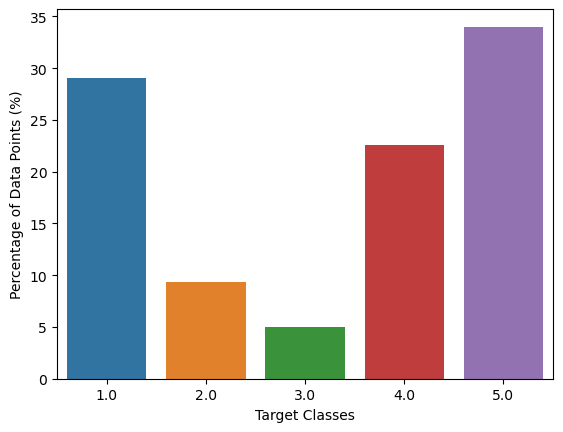

In [21]:
# Get the value counts for the target column
target_counts = dataset_resampled['acuity'].value_counts()

# Calculate the percentage of data points for each class
target_percentage = target_counts / dataset_resampled.shape[0] * 100

# Plot the distribution using seaborn
sns.barplot(x=target_percentage.index, y=target_percentage.values)
plt.xlabel('Target Classes')
plt.ylabel('Percentage of Data Points (%)')
plt.show()

In [22]:
# Count the amount of data after preprocessing
count = len(dataset_resampled)
print("Data count after sampling: ", count)

Data count after sampling:  63713


In [23]:
dataset_resampled.tail()

,temperature,heartrate,resprate,o2sat,sbp,dbp,acuity
63708,0.098934,0.078520,0.008791,0.010469,0.006001,0.000128,5.0
63709,0.099087,0.091126,0.009881,0.010411,0.005938,0.000106,5.0
63710,0.099338,0.082849,0.008791,0.010662,0.006804,0.000104,5.0
63711,0.099171,0.071300,0.009587,0.010572,0.008182,0.000136,5.0
63712,0.099941,0.077313,0.009161,0.010585,0.006136,0.000113,5.0


In [24]:
dataset_resampled.to_csv('preprocessed_classif_data.csv', index=False)

---

# Load Preprocessed Data

In [25]:
classif_dataset = pd.read_csv('/kaggle/working/preprocessed_classif_data.csv')
# classif_dataset = dataset_resampled

## Data Split - Diagnostic Stage

In [26]:
# Define the features and the target for the diagnostic stage
x_diagnosis = classif_dataset[['temperature','heartrate','resprate','o2sat','sbp','dbp']]
y_diagnosis = classif_dataset['acuity']

In [27]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(x_diagnosis, y_diagnosis, test_size=0.2, random_state=42)

## Stacking Classifier

The stacking classifier performs training for each individual model and then combines them taking the best of each model to create a hybrid model which will do the predictions

In [28]:
#Ensemble method for combining multiple classifiers
from sklearn.ensemble import StackingClassifier

# Model Classifiers Used
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier

#Initializing Classifiers
dt_model = DecisionTreeClassifier(random_state=42)
gb_model = GradientBoostingClassifier(random_state=42)
rf_model = RandomForestClassifier(random_state=42)

In [31]:
# Creating the hybrid model using the voting classifier
hybrid_model = StackingClassifier(estimators=[('rf', rf_model), ('dt', dt_model),('gb', gb_model)])

In [32]:
# Fitting the voting classifier on the training data
hybrid_model.fit(X_train, y_train)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


StackingClassifier(estimators=[('rf', RandomForestClassifier(random_state=42)),
                               ('dt', DecisionTreeClassifier(random_state=42)),
                               ('gb',
                                GradientBoostingClassifier(random_state=42))])

In [33]:
# Making predictions on the test set
predictions = hybrid_model.predict(X_test)

In [34]:
print(predictions)

[1. 5. 5. ... 1. 4. 4.]


In [35]:
# Evaluating the model on the test set
accuracy = hybrid_model.score(X_test, y_test)
print("Accuracy: ", accuracy)

Accuracy:  0.9364356901828454


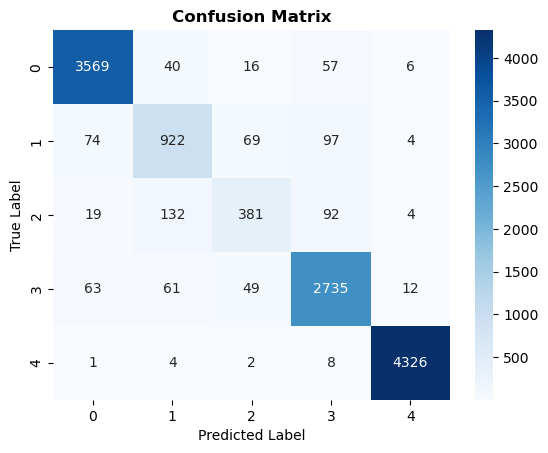

Accuracy score: 93.64356901828455
Recall score: [0.96773319 0.79073756 0.6066879  0.93664384 0.99654457]
Precision score: [0.95786366 0.79551337 0.73694391 0.91502175 0.99402574]
              precision    recall  f1-score   support

         1.0       0.96      0.97      0.96      3688
         2.0       0.80      0.79      0.79      1166
         3.0       0.74      0.61      0.67       628
         4.0       0.92      0.94      0.93      2920
         5.0       0.99      1.00      1.00      4341

    accuracy                           0.94     12743
   macro avg       0.88      0.86      0.87     12743
weighted avg       0.93      0.94      0.94     12743



In [36]:
# Creating a confusion matrix 
cf_matrix = confusion_matrix(y_test, predictions)

sns.heatmap(cf_matrix, annot=True, fmt='d', cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix",  weight='bold')
plt.show()

#Printing Accuracy, Recall and Precision Scores
ac = accuracy_score(y_test, predictions)
rs = recall_score(y_test, predictions, average=None)
ps = precision_score(y_test, predictions, average=None)
print("Accuracy score: " + str(ac*100))
print("Recall score: " + str(rs))
print("Precision score: " + str(ps))

# Print the evaluation of the model
print(classification_report(y_test, predictions))

In [37]:
from sklearn.metrics import confusion_matrix

# Calculate the confusion matrix
cm = confusion_matrix(y_test, predictions)

# Calculate the observed agreement
po = sum(np.diag(cm)) / np.sum(cm)

# Calculate the expected agreement
pe = np.sum(np.sum(cm, axis=0) * np.sum(cm, axis=1)) / np.sum(cm)**2

# Calculate Cohen's kappa score
kappa = (po - pe) / (1 - pe)

print("Cohen's kappa score: ", kappa)

Cohen's kappa score:  0.9135138176017596


The Kappa Score of 0.91 shows that your hybrid classification model is functioning properly on the test data and correctly predicting the class labels.

## Export the Model

In [38]:
import pickle

# Dump the model to a file
with open('hybridmodel.pkl', 'wb') as file:
    pickle.dump(hybrid_model, file)

----

# Loading the saved model
Performing classification using the model

In [39]:
import pickle

In [40]:
with open('status_scaler.pkl', 'rb') as file:
        status_min_value, status_max_value = pickle.load(file)
        print('Loaded Status Scaler')


with open('hybridmodel.pkl', 'rb') as file:
        model = pickle.load(file)
        print('Loaded Model')

Loaded Status Scaler
Loaded Model


### Formatting the data

In [41]:
data = [[98.6, 70, 16, 98, 120, 80]]

In [42]:
input_data = np.array(data)  # Convert the data to a numpy array
input_data

array([[ 98.6,  70. ,  16. ,  98. , 120. ,  80. ]])

In [43]:
# Reshape the input data if it's a 1D array
if input_data.ndim == 1:
    input_data = input_data.reshape(1, -1)

### Normalize the input data

In [44]:
normalized_input = (input_data - status_min_value) / (status_max_value - status_min_value)

### Performing Classification

In [45]:
# Use the model to make predictions
predictions = model.predict(normalized_input)
print("Patient Health Status Classification: ", predictions)

Patient Health Status Classification:  [4.]


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"
/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  "X does not have valid feature names, but"
/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  "X does not have valid feature names, but"
